# 350 book 2

This is a jupyter notebook illustrating the peak detection, spike sorting by k-means clustering, and frequency analysis of extracellular data from an abf file.

It requires installation of neo (pip install neo).

To execute each cell and advance to the next, hit shift+enter.

If all has gone well this week, you have two different and quite interesting datasets to play with for your
next figure. There are many different sorts of analyses you could perform for each of the datasets –
refer to our prompts on lab manual pages 27-8 and the crawdad prompts on pages 89 and 91.

Whether you are trying to analyze changes in synaptic strength from your plasticity experiments, or do
some spike sorting and see which spike classes correspond the junction potentials in your paired
recording, there is a core set of analysis tools it would be handy to have at your disposal.

__Peak detection__ refers to the identification of the time coordinate and amplitude of spikes or junction
potentials. With those coordinates, you are able to do spike sorting as well as frequency analysis.
__Spike sorting__ refers to separating your spikes into classes or “units” corresponding to the activity of
different individual neurons. (Recall that the crayfish sN3 has 6 dominant axons.) There are many ways
to sort – it can be as crude as “eyeballing it” or involve comparing the specific shapes of each action
potential. The method we present here involves taking your peaks identified by thresholding and then
__clustering__ them.[1] You can also do frequency analysis: if your frequency is stable over time, then it may
be adequate to report the average firing rate over time; if you’re considering changes in frequency, it
is most sensible to look at the __instantaneous firing rate__ (IFR). The IFR is defined as the reciprocal of the
inter-spike interval, which is the time between two successive spikes.

__Disclaimer__: This document does not represent the scope of analysis we expect you to perform for
your next figure. We would much prefer you to give some thought to this toolbox of techniques in
light of the data you collected this week, and to be selective about what you choose to implement,
than to have you paste all the commands without understanding what you’re actually doing.

***

[1] We illustrate this approach with k-means clustering because it’s quick and easy. It can be argued that
other approaches are better for 1-d data (e.g., natural break segmentation), but we’ll leave that to you
to sort out if you become interested. All of these approaches have limitations, first among which is that
some of the axons in sN3 have very similar diameters, which makes separating them by amplitude
difficult.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import neo
from scipy.signal import medfilt
from scipy.ndimage import label
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
# read in the data
data_file = 'sample2.abf'
r = neo.AxonIO(filename=data_file)
block = r.read_block()
segment = block.segments[0]

nerve,muscle = segment.analogsignals
# this tutorial supposes a two channel recording with nerve and muscle data
# (even though the steps are only looking at the nerve record)
# You should figure out which of these tools make sense for your data.

Depending on the length of a data file, I often tend to narrow my scope for the first pass of analysis. If
things go smoothly and you want to increase your statistical power, you can then go back and run the
rest of your data through your scripts once you have them polished. I also like to avoid the first half-second
or so when signal filters are on, so I don’t have to worry about the time it takes for the signal to
reach zero. 100k samples at 10kHz is 10s of data, which is a quantity I find workable most of the time.

In [3]:
nerve = np.asarray(nerve[100001:200000]) # crop the data for first-pass analysis

The next step will median filter to adjust for slow drift in your baseline.  This step is optional, and you can feel free to skip it if it makes your computer hang up for longer than you would like.

You can uncomment the plot commands to observe the difference and see that the filtering will give you higher confidence of spike amplitudes called during peak detection. (I consider this good practice for almost all of the steps in these tutorials.)

In [ ]:
# adjust for baseline drift; may take a bit of time, especially for a large file

#pl.plot(nerve)
baseline = medfilt(nerve, kernel_size=801)
nerve -= baseline
#pl.plot(nerve)

Peak detection is done in two steps.  First we tag all of the data that lies above a threshold.  Here the threshold is defined as 2.5 SD above the average signal from data.  You should play with this value and see how it affects your capacity to detect what you perceive by eye to be action potentials.

In [4]:
# compute the values in the signal that pass some threshold
direction = 1 # 1 for upward, -1 for downward
n_std = 2.5
thresh = nerve.mean() + nerve.std() * n_std
above_thresh = direction * nerve > thresh    # boolean array

Now find the local maxima in the segments above threshold.  This script won't find overlapping APs if the signal doesn't drop to baseline in between them.  I'll leave it to you to think about how to address that.

In [5]:
# split the above_thresh signal into connected segments
labs,nlabs = label(above_thresh)

peak_idxs = [] # stores the indices of peaks

# iterate through each segment
for l in range(1,nlabs+1):
    
    # find the indices of this segment
    idxs = np.where(labs==l)[0]
    
    # extract the signal values at these idxs
    vals = nerve[idxs]
    
    # select the index corresponding to the peak signal value
    peak_idx = idxs[np.argmax(vals)]
    
    peak_idxs.append(peak_idx)

peak_heights = nerve[peak_idxs] # we want the voltage at those peaks, too.

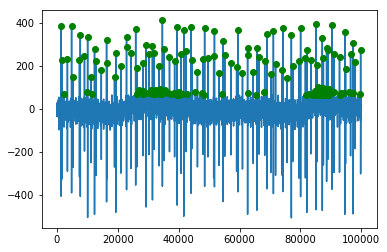

In [6]:
# display the discovered peaks
pl.figure(1)
pl.plot(nerve)
pl.plot(peak_idxs, peak_heights, 'go')

Next we will segment our peaks into units using k-means clustering.  Play with k and assess the performance of the sorting.

Recall that several of the AP units occur around the same height, so naive clustering of any sort may not properly segment them.  How could you get around this?

Text(0, 0.5, 'Count')

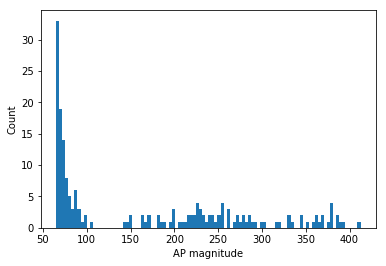

In [7]:
# display the distribution of peak values (might help you see clusters, and thus select k for k-means)
pl.figure(2)
pl.hist(peak_heights, bins=100)
pl.xlabel('AP magnitude')
pl.ylabel('Count')

In [8]:
n_clusters = 5

# reshape the data to the shape (n_samples, n_features) -- required for scikit-learn
X = peak_heights.reshape([-1,1])
# run k-means clustering
km = KMeans(n_clusters=n_clusters).fit(X)

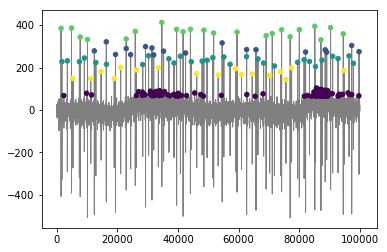

In [9]:
# display the nerve and the peaks colored by cluster
pl.figure(3)
pl.plot(nerve, color='gray', lw=1)
pl.scatter(peak_idxs, peak_heights, c=km.labels_, s=20, zorder=10)

Now with your clusters defined, let's look at the instantaneous firing rate of one of the clusters. 

(Note: I am not suggesting that a particular unit's IFR should be of interest; but if this makes sense you now know how to isolate a particular cluster as well as make a plot of IFR.)

In [10]:
# pull out cluster 3
cls3_tms = []
cls3_amp = []

for i in range(len(peak_idxs)):
    if(km.labels_[i] == 3):
        cls3_tms.append(peak_idxs[i])
        cls3_amp.append(peak_heights[i])


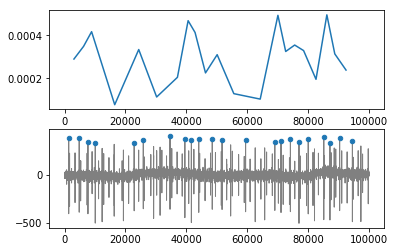

In [11]:
# instantaneous firing rate is the reciprocal of the interval
# np.diff is an array of the differences between the values of your array.
ifr = 1/np.diff(cls3_tms)

# let's call the time coords the average times of the peaks in question
ifr_t = []
for i in range(len(cls3_tms)):
    if(i+1 < len(cls3_tms)):
        ifr_t.append( (cls3_tms[i] + cls3_tms[i+1]) / 2.0 )

pl.figure(4)

ax1 = pl.subplot(211)
pl.plot(ifr_t, ifr)

ax2 = pl.subplot(212, sharex=ax1)
pl.plot(nerve, color='gray', lw=1)
pl.scatter(cls3_tms, cls3_amp, s=20, zorder=10)